# Setup libraries

In [ ]:
!pip install numpy tensorflow tqdm matplotlib torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
import copy

# Setup neural network

In [ ]:
class SimpleCNN(nn.Module):
    """Simple CNN for CIFAR-10 classification"""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Attack implementation


PGD

In [ ]:
def custom_pgd_attack(model, images, labels, epsilon=8/255, alpha=2/255, num_iter=10):
    """Custom PGD implementation"""
    images = images.clone().detach().to(images.device)
    labels = labels.clone().detach().to(labels.device)

    delta = torch.empty_like(images).uniform_(-epsilon, epsilon)
    delta.requires_grad = True

    for _ in range(num_iter):
        outputs = model(images + delta)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        grad_sign = delta.grad.data.sign()
        delta.data = delta.data + alpha * grad_sign
        delta.data = torch.clamp(delta.data, -epsilon, epsilon)
        delta.data = torch.clamp(images.data + delta.data, 0, 1) - images.data

        delta.grad.zero_()

    return images + delta.detach()

DeepFool

In [ ]:
def custom_deepfool_attack(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    """Custom DeepFool implementation"""
    image = image.clone().detach().unsqueeze(0)
    image.requires_grad = True

    model.eval()
    original_output = model(image)
    original_label = original_output.argmax(dim=1).item()

    perturb = torch.zeros_like(image)

    for _ in range(max_iter):
        outputs = model(image + perturb)
        current_label = outputs.argmax(dim=1).item()

        if current_label != original_label:
            break

        grads = []
        for k in range(num_classes):
            if k == original_label:
                continue

            if image.grad is not None:
                image.grad.zero_()

            outputs[0, k].backward(retain_graph=True)
            grad = image.grad.clone()
            grads.append(grad)

        min_distance = float('inf')
        min_grad = None
        original_score = outputs[0, original_label]

        for i, k in enumerate([j for j in range(num_classes) if j != original_label]):
            w = grads[i].flatten()
            f = outputs[0, k] - original_score
            distance = abs(f.item()) / (torch.norm(w).item() + 1e-10)

            if distance < min_distance:
                min_distance = distance
                min_grad = grads[i]

        if min_grad is not None:
            r = (min_distance + 1e-4) * min_grad / (torch.norm(min_grad) + 1e-10)
            perturb = perturb + r

    return (image + (1 + overshoot) * perturb).squeeze(0).detach()

# Defense implementations

In [ ]:
def compute_jacobian_regularization(model, images, labels, lambda_reg=0.01):
    """
    Compute Jacobian regularization term
    Encourages smoothness in model predictions

    Args:
        model: Neural network model
        images: Input images
        labels: True labels
        lambda_reg: Regularization strength

    Returns:
        Total loss (cross-entropy + Jacobian regularization)
    """
    images.requires_grad = True
    outputs = model(images)

    # Standard cross-entropy loss
    ce_loss = F.cross_entropy(outputs, labels)

    # Compute Jacobian regularization (Frobenius norm of gradients)
    jacobian_reg = 0
    num_classes = outputs.size(1)

    for i in range(num_classes):
        if images.grad is not None:
            images.grad.zero_()

        outputs_i = outputs[:, i].sum()
        outputs_i.backward(retain_graph=True)

        grad_norm = torch.norm(images.grad, p=2)
        jacobian_reg += grad_norm ** 2

    jacobian_reg = jacobian_reg / (num_classes * images.size(0))

    total_loss = ce_loss + lambda_reg * jacobian_reg
    return total_loss

# Training procedures

Normal training

In [ ]:
#the k of the folds
def train_standard(model, dataset, optimizer, device, k=5, epochs=10, patience=3):
    """Training with K-Fold Cross-Validation and Early Stopping"""
    kfold = KFold(n_splits=k, shuffle=True)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'\nFold {fold + 1}/{k}')

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

        model.train()

        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct = 0
            total = 0

            pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Train]')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix({'loss': total_loss/total, 'acc': 100.*correct/total})

            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                pbar_val = tqdm(val_loader, desc=f'Fold {fold + 1} [Val]')
                for images, labels in pbar_val:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = F.cross_entropy(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    pbar_val.set_postfix({'val_loss': val_loss/val_total, 'val_acc': 100.*val_correct/val_total})

            avg_val_loss = val_loss / len(val_loader)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        model.load_state_dict(best_model_wts)

        fold_results.append({
            'train_loss': total_loss / len(train_loader),
            'train_acc': 100. * correct / total,
            'val_loss': avg_val_loss,
            'val_acc': 100. * val_correct / val_total
        })

    avg_train_loss = sum(f['train_loss'] for f in fold_results) / k
    avg_train_acc = sum(f['train_acc'] for f in fold_results) / k
    avg_val_loss = sum(f['val_loss'] for f in fold_results) / k
    avg_val_acc = sum(f['val_acc'] for f in fold_results) / k

    print(f"\nAverage Results after {k} folds:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.2f}%")

    return avg_train_loss, avg_train_acc

Adversarial training

In [ ]:
def train_adversarial(model, train_loader, optimizer, device, epoch, epsilon=8/255):
    """Adversarial training defense - train on adversarial examples"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [Adversarial Training]')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        model.eval()  # Set to eval mode for attack generation
        adv_images = custom_pgd_attack(model, images, labels, epsilon=epsilon)
        model.train()  # Back to train mode

        # Train on adversarial examples
        optimizer.zero_grad()
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': total_loss/total, 'acc': 100.*correct/total})

    return total_loss / len(train_loader), 100. * correct / total

In [ ]:
import random

def train_adversarial(model, dataset, optimizer, device, attack_type, epochs=10, k=5, patience=3, epsilon=8/255):
    """Adversarial training defense - Train on adversarial examples with K-Fold Cross-Validation and Early Stopping"""

    # Hardcoded parameters for KFold and early stopping
    kfold = KFold(n_splits=k, shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'\nFold {fold + 1}/{k}')

        # Prepare the train and validation data loaders for this fold
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

        # Initialize early stopping parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())

        # Training loop for each fold
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct = 0
            total = 0

            pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Adversarial Training]')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                # Generate adversarial examples using attack
                model.eval()  # Set to eval mode for attack generation
                adv_images = None
                if attack_type == 'pgd':
                  adv_images = custom_pgd_attack(model, images, labels, epsilon=epsilon)
                elif attack_type == 'deepfool':
                  adv_images_list = []
                  for i in range(images.size(0)):
                    adv_images_list.append(custom_deepfool_attack(model, images[i]))
                  adv_images = torch.stack(adv_images_list)
                elif attack_type == 'none':
                  adv_images = images
                elif attack_type == 'both':
                  adv_images_pgd = custom_pgd_attack(model, images, labels, epsilon=epsilon)
                  adv_images_deepfool_list = []
                  for i in range(images.size(0)):
                    adv_images_deepfool_list.append(custom_deepfool_attack(model, images[i]))
                  adv_images_deepfool = torch.stack(adv_images_deepfool_list)

                  # Combine the adversarial images for random sampling
                  # Convert tensors to lists of individual images, combine, then stack back
                  combined_adv_images_list = adv_images_pgd.unbind(0) + adv_images_deepfool.unbind(0)
                  selected_adv_images_list = random.sample(combined_adv_images_list, len(images))
                  adv_images = torch.stack(selected_adv_images_list)
                model.train()  # Back to train mode

                # Train on adversarial examples
                optimizer.zero_grad()
                outputs = model(adv_images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix({'loss': total_loss / total, 'acc': 100. * correct / total})

            # Validation step after each epoch
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                pbar_val = tqdm(val_loader, desc=f'Fold {fold + 1} [Validation]')
                for images, labels in pbar_val:
                    images, labels = images.to(device), labels.to(device)

                    # Perform validation on original images (not adversarial)
                    outputs = model(images)
                    loss = F.cross_entropy(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    pbar_val.set_postfix({'val_loss': val_loss / val_total, 'val_acc': 100. * val_correct / val_total})

            avg_val_loss = val_loss / len(val_loader)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
            else:
                epochs_no_improve += 1

            # If no improvement for 'patience' epochs, stop early
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Restore the best model weights after training
        model.load_state_dict(best_model_wts)

        # Store the results for this fold
        fold_results.append({
            'train_loss': total_loss / len(train_loader),
            'train_acc': 100. * correct / total,
        })

    # Compute average results across all folds
    avg_train_loss = sum(f['train_loss'] for f in fold_results) / k
    avg_train_acc = sum(f['train_acc'] for f in fold_results) / k

    print(f"\nAverage Results after {k} folds:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.2f}%")

    return avg_train_loss, avg_train_acc

Jacobian reg. training

In [ ]:
def train_jacobian(model, train_loader, optimizer, device, epoch, lambda_reg=0.01):
    """Train with Jacobian regularization defense"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [Jacobian Reg]')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = compute_jacobian_regularization(model, images, labels, lambda_reg)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        with torch.no_grad():
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        total_loss += loss.item()
        pbar.set_postfix({'loss': total_loss/total, 'acc': 100.*correct/total})

    return total_loss / len(train_loader), 100. * correct / total



In [ ]:
# DA K OF DA FOLDS
def train_jacobian(model, dataset, optimizer, device, epochs=10, k=5, patience=3, lambda_reg=0.01):
    """Train with Jacobian regularization defense with K-Fold Cross-Validation and Early Stopping"""

    # Hardcoded parameters for KFold and early stopping
    kfold = KFold(n_splits=k, shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'\nFold {fold + 1}/{k}')

        # Prepare the train and validation data loaders for this fold
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

        # Initialize early stopping parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())

        # Training loop for each fold
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct = 0
            total = 0

            pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Jacobian Regularization]')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                loss = compute_jacobian_regularization(model, images, labels, lambda_reg)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = model(images).max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix({'loss': total_loss / total, 'acc': 100. * correct / total})

            # Validation step after each epoch
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                pbar_val = tqdm(val_loader, desc=f'Fold {fold + 1} [Validation]')
                for images, labels in pbar_val:
                    images, labels = images.to(device), labels.to(device)

                    # Perform validation on original images (not adversarial)
                    outputs = model(images)
                    loss = F.cross_entropy(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    pbar_val.set_postfix({'val_loss': val_loss / val_total, 'val_acc': 100. * val_correct / val_total})

            avg_val_loss = val_loss / len(val_loader)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
            else:
                epochs_no_improve += 1

            # If no improvement for 'patience' epochs, stop early
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Restore the best model weights after training
        model.load_state_dict(best_model_wts)

        # Store the results for this fold
        fold_results.append({
            'train_loss': total_loss / len(train_loader),
            'train_acc': 100. * correct / total,
        })

    # Compute average results across all folds
    avg_train_loss = sum(f['train_loss'] for f in fold_results) / k
    avg_train_acc = sum(f['train_acc'] for f in fold_results) / k

    print(f"\nAverage Results after {k} folds:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.2f}%")

    return avg_train_loss, avg_train_acc

Evaluation

In [ ]:
import time

def deepfool_batch(model, images):
    # Helper function to apply custom_deepfool_attack to a batch of images
    adv_images_list = []
    for i in range(images.size(0)):
        adv_images_list.append(custom_deepfool_attack(model, images[i]))
    return torch.stack(adv_images_list)

def evaluate(model, test_loader, device, attack_type=None, epsilon=8/255):
    """
    Evaluate model on clean or adversarial examples

    Args:
        model: Neural network model
        test_loader: Test data loader
        device: Device to run on
        attack_type: 'pgd', 'deepfool', or None for clean evaluation
        epsilon: Attack strength

    Returns:
        Accuracy percentage, time taken
    """
    model.eval()
    correct = 0
    total = 0

    desc = f'Evaluating [{attack_type if attack_type else "Clean"}]'
    pbar = tqdm(test_loader, desc=desc)

    start_time = time.time()

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples if attack specified
        if attack_type == 'pgd':
            images = images.clone().detach().to(images.device)
            labels = labels.clone().detach().to(labels.device)
            images = custom_pgd_attack(model, images, labels, epsilon=epsilon)
        elif attack_type == 'deepfool':
             with torch.no_grad(): # DeepFool does not require gradients for the original images in the evaluation loop
                 images = deepfool_batch(model, images)

        with torch.no_grad(): # Evaluate the model without gradient computation
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'acc': 100.*correct/total})

    end_time = time.time()
    accuracy = 100. * correct / total
    time_taken = end_time - start_time
    return accuracy, time_taken

# Main experiment using implementations

In [ ]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Create model
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


In [ ]:
epoch_count = 10 # Define the number of epochs for the k-fold training functions

train_loss, train_acc = train_standard(model, train_dataset, optimizer, device, k=5, epochs=epoch_count, patience=3)
print(f'Standard Training Complete: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%')

# Evaluate
clean_acc = evaluate(model, test_loader, device, attack_type=None)
pgd_acc = evaluate(model, test_loader, device, attack_type='pgd', epsilon=8/255)

print(f'Clean Accuracy: {clean_acc[0]:.2f}%')
print(f'PGD Attack Accuracy: {pgd_acc[0]:.2f}%')


Fold 1/5


Fold 1 [Val]: 100%|██████████| 157/157 [00:03<00:00, 50.85it/s, val_loss=0.00949, val_acc=79.1]


Early stopping at epoch 6

Fold 2/5


Fold 2 [Val]: 100%|██████████| 157/157 [00:03<00:00, 42.69it/s, val_loss=0.0096, val_acc=78.8]


Early stopping at epoch 7

Fold 3/5


Fold 3 [Val]: 100%|██████████| 157/157 [00:03<00:00, 43.13it/s, val_loss=0.00895, val_acc=79.9]


Early stopping at epoch 6

Fold 4/5


Fold 4 [Val]: 100%|██████████| 157/157 [00:03<00:00, 44.10it/s, val_loss=0.00898, val_acc=80]


Early stopping at epoch 6

Fold 5/5


Fold 5 [Val]: 100%|██████████| 157/157 [00:03<00:00, 43.26it/s, val_loss=0.00887, val_acc=80.3]


Early stopping at epoch 4

Average Results after 5 folds:
Train Loss: 0.6289, Train Accuracy: 78.36%
Validation Loss: 0.5847, Validation Accuracy: 79.62%
Standard Training Complete: Loss=0.6289, Train Acc=78.36%


Evaluating [pgd]: 100%|██████████| 79/79 [00:04<00:00, 19.09it/s, acc=0.03]

Clean Accuracy: 80.36%
PGD Attack Accuracy: 0.03%


In [ ]:
# Create new model
model_adv = SimpleCNN().to(device)
optimizer_adv = torch.optim.Adam(model_adv.parameters(), lr=0.001)

# Train with adversarial examples
epoch_count = 10 # Number of epochs for the k-fold training
train_loss, train_acc = train_adversarial(model_adv, train_dataset, optimizer_adv, device, attack_type='pgd', k=5, epochs=epoch_count, patience=3, epsilon=8/255)
print(f'Adversarial Training Complete: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%')

# Evaluate
clean_acc = evaluate(model_adv, test_loader, device, attack_type=None)
pgd_acc = evaluate(model_adv, test_loader, device, attack_type='pgd', epsilon=8/255)

print(f'Clean Accuracy: {clean_acc[0]:.2f}%')
print(f'PGD Attack Accuracy: {pgd_acc[0]:.2f}%')


Fold 1/5


Fold 1 [Validation]: 100%|██████████| 157/157 [00:03<00:00, 47.89it/s, val_loss=0.0261, val_acc=41.7]



Fold 2/5


Fold 2 [Validation]: 100%|██████████| 157/157 [00:03<00:00, 50.02it/s, val_loss=0.025, val_acc=45]



Fold 3/5


Fold 3 [Validation]: 100%|██████████| 157/157 [00:03<00:00, 42.15it/s, val_loss=0.025, val_acc=44.7]


Early stopping at epoch 5

Fold 4/5


Fold 4 [Validation]: 100%|██████████| 157/157 [00:03<00:00, 50.91it/s, val_loss=0.025, val_acc=45.6]


Early stopping at epoch 6

Fold 5/5


Fold 5 [Validation]: 100%|██████████| 157/157 [00:03<00:00, 51.13it/s, val_loss=0.025, val_acc=45.3]


Early stopping at epoch 4

Average Results after 5 folds:
Train Loss: 1.9592, Train Accuracy: 27.23%
Adversarial Training Complete: Loss=1.9592, Train Acc=27.23%


Evaluating [pgd]: 100%|██████████| 79/79 [00:04<00:00, 17.33it/s, acc=30]

Clean Accuracy: 46.88%
PGD Attack Accuracy: 29.97%


In [ ]:
# Create new model
model_jac = SimpleCNN().to(device)
optimizer_jac = torch.optim.Adam(model_jac.parameters(), lr=0.001)

# Train with Jacobian regularization
epoch_count = 10 # Number of epochs for the k-fold training
train_loss, train_acc = train_jacobian(model_jac, train_dataset, optimizer_jac, device, k=5, epochs=epoch_count, patience=3, lambda_reg=0.01)
print(f'Jacobian Regularization Training Complete: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%')

# Evaluate
clean_acc = evaluate(model_jac, test_loader, device, attack_type=None)
pgd_acc = evaluate(model_jac, test_loader, device, attack_type='pgd', epsilon=8/255)

print(f'Clean Accuracy: {clean_acc[0]:.2f}%')
print(f'PGD Attack Accuracy: {pgd_acc[0]:.2f}%')

In [ ]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Test PGD attack
adv_images_pgd = custom_pgd_attack(model, images, labels, epsilon=8/255)

# Test DeepFool attack (on single image)
single_image = images[0]
adv_image_deepfool = custom_deepfool_attack(model, single_image)

# Compare predictions
with torch.no_grad():
    clean_pred = model(images).argmax(dim=1)
    pgd_pred = model(adv_images_pgd).argmax(dim=1)

print("Clean predictions:", clean_pred[:10])
print("PGD adversarial predictions:", pgd_pred[:10])
print("True labels:", labels[:10])

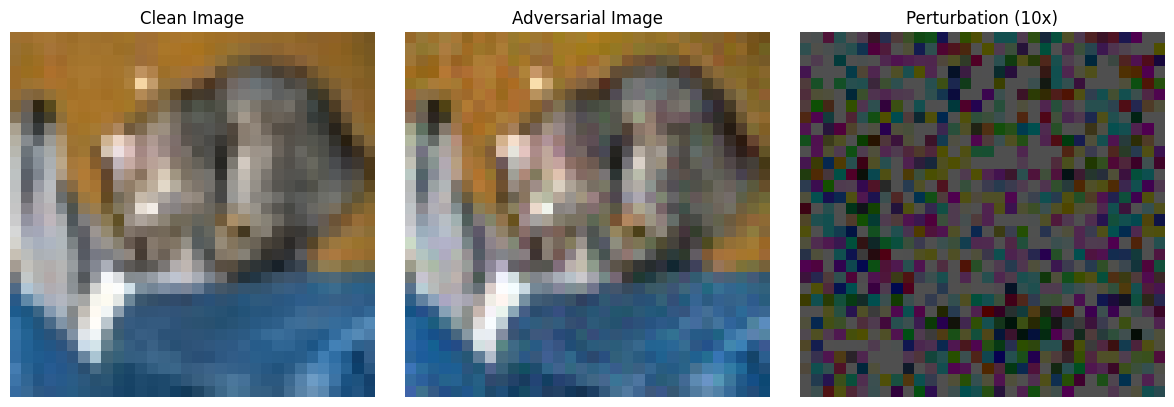

Max perturbation: 0.0314
L2 norm: 1.4193


In [ ]:
import matplotlib.pyplot as plt

# Get one image
img = images[0].cpu()
adv_img = adv_images_pgd[0].cpu()

# Calculate perturbation
perturbation = (adv_img - img).abs()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title('Clean Image')
axes[0].axis('off')

axes[1].imshow(adv_img.permute(1, 2, 0))
axes[1].set_title('Adversarial Image')
axes[1].axis('off')

axes[2].imshow(perturbation.permute(1, 2, 0) * 10)  # Amplified for visibility
axes[2].set_title('Perturbation (10x)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Max perturbation: {perturbation.max():.4f}")
print(f"L2 norm: {perturbation.norm():.4f}")

# State of the art implementations

In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import time

# ART imports
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent, DeepFool

# Comparisson to custom implementation

In [ ]:
def evaluate_custom_pgd(model, test_loader, device, epsilon=8/255, max_samples=1000):
    """Evaluate using custom PGD implementation"""
    model.eval()
    correct = 0
    total = 0
    times = []

    for images, labels in tqdm(test_loader, desc='Custom PGD'):
        if total >= max_samples:
            break

        images, labels = images.to(device), labels.to(device)

        start_time = time.time()
        adv_images = custom_pgd_attack(model, images, labels, epsilon=epsilon)
        times.append(time.time() - start_time)

        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_time = np.mean(times)
    return accuracy, avg_time


def evaluate_art_pgd(classifier, test_loader, epsilon=8/255, max_samples=1000):
    """Evaluate using ART PGD implementation"""
    pgd_attack = ProjectedGradientDescent(
        estimator=classifier,
        eps=epsilon,
        eps_step=epsilon/4,
        max_iter=10,
        num_random_init=1,
        verbose=False
    )

    correct = 0
    total = 0
    times = []

    for images, labels in tqdm(test_loader, desc='ART PGD'):
        if total >= max_samples:
            break

        x_batch = images.numpy()
        y_batch = labels.numpy()

        start_time = time.time()
        x_adv = pgd_attack.generate(x=x_batch)
        times.append(time.time() - start_time)

        predictions = classifier.predict(x_adv)
        predicted_labels = np.argmax(predictions, axis=1)

        total += len(y_batch)
        correct += np.sum(predicted_labels == y_batch)

    accuracy = 100. * correct / total
    avg_time = np.mean(times)
    return accuracy, avg_time



def calculate_perturbation_metrics(model, test_loader, device, attack_fn, epsilon=8/255, max_samples=100):
    """Calculate L2 and L-inf norms of perturbations"""
    model.eval()
    l2_norms = []
    linf_norms = []

    for images, labels in test_loader:
        if len(l2_norms) >= max_samples:
            break

        images, labels = images.to(device), labels.to(device)

        if 'custom' in attack_fn.__name__:
            adv_images = attack_fn(model, images, labels, epsilon=epsilon)
        else:
            # For DeepFool
            for i in range(images.size(0)):
                if len(l2_norms) >= max_samples:
                    break
                adv_img = attack_fn(model, images[i])
                perturbation = (adv_img - images[i]).abs()
                l2_norms.append(perturbation.norm(p=2).item())
                linf_norms.append(perturbation.max().item())
            continue

        perturbation = (adv_images - images).abs()
        for i in range(perturbation.size(0)):
            if len(l2_norms) >= max_samples:
                break
            l2_norms.append(perturbation[i].norm(p=2).item())
            linf_norms.append(perturbation[i].max().item())

    return {
        'l2_mean': np.mean(l2_norms),
        'l2_std': np.std(l2_norms),
        'linf_mean': np.mean(linf_norms),
        'linf_std': np.std(linf_norms)
    }

In [ ]:
def evaluate_custom_deepfool(model, test_loader, device, max_samples=200):
    """Evaluate using custom DeepFool implementation"""
    model.eval()
    correct = 0
    total = 0
    times = []

    for images, labels in tqdm(test_loader, desc='Custom DeepFool'):
        if total >= max_samples:
            break

        images, labels = images.to(device), labels.to(device)

        for i in range(images.size(0)):
            if total >= max_samples:
                break

            start_time = time.time()
            adv_img = custom_deepfool_attack(model, images[i])
            times.append(time.time() - start_time)

            with torch.no_grad():
                output = model(adv_img.unsqueeze(0))
                predicted = output.argmax(dim=1).item()
                total += 1
                if predicted == labels[i].item():
                    correct += 1

    accuracy = 100. * correct / total
    avg_time = np.mean(times)
    return accuracy, avg_time


def evaluate_art_deepfool(classifier, test_loader, max_samples=200):
    """Evaluate using ART DeepFool implementation"""
    deepfool_attack = DeepFool(
        classifier=classifier,
        max_iter=50,
        epsilon=1e-6,
        nb_grads=10,
        batch_size=1,
        verbose=False
    )

    correct = 0
    total = 0
    times = []

    for images, labels in tqdm(test_loader, desc='ART DeepFool'):
        if total >= max_samples:
            break

        x_batch = images.numpy()
        y_batch = labels.numpy()

        start_time = time.time()
        x_adv = deepfool_attack.generate(x=x_batch)
        times.append(time.time() - start_time)

        predictions = classifier.predict(x_adv)
        predicted_labels = np.argmax(predictions, axis=1)

        total += len(y_batch)
        correct += np.sum(predicted_labels == y_batch)

    accuracy = 100. * correct / total
    avg_time = np.mean(times)
    return accuracy, avg_time

In [ ]:
def main():
    print("="*70)
    print("CUSTOM vs STATE-OF-THE-ART ADVERSARIAL ML COMPARISON")
    print("="*70)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'\nUsing device: {device}')

    # Load data
    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

    # Load or train a simple model
    print("\nTraining a simple model for comparison...")
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Quick training (3 epochs)
    for epoch in range(1, 4):
        model.train()
        for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate clean accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    clean_acc = 100. * correct / total
    print(f"\nClean Accuracy: {clean_acc:.2f}%")

    # Wrap model in ART classifier
    criterion = nn.CrossEntropyLoss()
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 32, 32),
        nb_classes=10,
    )

    epsilon = 8/255

    print("\n" + "="*70)
    print("PGD ATTACK COMPARISON")
    print("="*70)

    # Custom PGD
    print("\n[1/2] Evaluating Custom PGD...")
    custom_pgd_acc, custom_pgd_time = evaluate_custom_pgd(
        model, test_loader, device, epsilon=epsilon, max_samples=1000
    )

    # ART PGD
    print("\n[2/2] Evaluating ART PGD...")
    art_pgd_acc, art_pgd_time = evaluate_art_pgd(
        classifier, test_loader, epsilon=epsilon, max_samples=1000
    )

    # Calculate perturbation metrics for PGD
    print("\nCalculating perturbation metrics for PGD...")
    custom_pgd_metrics = calculate_perturbation_metrics(
        model, test_loader, device, custom_pgd_attack, epsilon=epsilon, max_samples=100
    )

    print("\n" + "-"*70)
    print("PGD RESULTS:")
    print("-"*70)
    print(f"{'Metric':<30} {'Custom':<20} {'ART (SOTA)':<20}")
    print("-"*70)
    print(f"{'Accuracy':<30} {custom_pgd_acc:<20.2f} {art_pgd_acc:<20.2f}")
    print(f"{'Avg Time per Batch (s)':<30} {custom_pgd_time:<20.4f} {art_pgd_time:<20.4f}")
    print(f"{'L2 Norm (mean)':<30} {custom_pgd_metrics['l2_mean']:<20.4f} {'N/A':<20}")
    print(f"{'L-inf Norm (mean)':<30} {custom_pgd_metrics['linf_mean']:<20.4f} {'N/A':<20}")
    print("-"*70)

    improvement_acc = art_pgd_acc - custom_pgd_acc
    improvement_time = ((custom_pgd_time - art_pgd_time) / custom_pgd_time) * 100

    print(f"\nART vs Custom:")
    print(f"  Accuracy difference: {improvement_acc:+.2f}%")
    print(f"  Speed improvement: {improvement_time:+.1f}%")

    print("\n" + "="*70)
    print("DEEPFOOL ATTACK COMPARISON")
    print("="*70)

    # Custom DeepFool
    print("\n[1/2] Evaluating Custom DeepFool...")
    custom_df_acc, custom_df_time = evaluate_custom_deepfool(
        model, test_loader, device, max_samples=200
    )

    # ART DeepFool
    print("\n[2/2] Evaluating ART DeepFool...")
    art_df_acc, art_df_time = evaluate_art_deepfool(
        classifier, test_loader, max_samples=200
    )

    print("\n" + "-"*70)
    print("DEEPFOOL RESULTS:")
    print("-"*70)
    print(f"{'Metric':<30} {'Custom':<20} {'ART (SOTA)':<20}")
    print("-"*70)
    print(f"{'Accuracy':<30} {custom_df_acc:<20.2f} {art_df_acc:<20.2f}")
    print(f"{'Avg Time per Sample (s)':<30} {custom_df_time:<20.4f} {art_df_time:<20.4f}")
    print("-"*70)

    improvement_acc_df = art_df_acc - custom_df_acc
    improvement_time_df = ((custom_df_time - art_df_time) / custom_df_time) * 100

    print(f"\nART vs Custom:")
    print(f"  Accuracy difference: {improvement_acc_df:+.2f}%")
    print(f"  Speed improvement: {improvement_time_df:+.1f}%")

    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"\nClean Accuracy: {clean_acc:.2f}%")
    print(f"\nPGD Attack:")
    print(f"  Custom:    {custom_pgd_acc:.2f}% (defender wins if higher)")
    print(f"  ART SOTA:  {art_pgd_acc:.2f}%")
    print(f"\nDeepFool Attack:")
    print(f"  Custom:    {custom_df_acc:.2f}%")
    print(f"  ART SOTA:  {art_df_acc:.2f}%")



if __name__ == '__main__':
    main()

CUSTOM vs STATE-OF-THE-ART ADVERSARIAL ML COMPARISON

Using device: cpu

Training a simple model for comparison...


Training Epoch 3: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]



Clean Accuracy: 62.98%

PGD ATTACK COMPARISON

[1/2] Evaluating Custom PGD...


Custom PGD:  10%|█         | 10/100 [00:24<03:36,  2.41s/it]



[2/2] Evaluating ART PGD...


ART PGD:  10%|█         | 10/100 [00:30<04:31,  3.02s/it]


Calculating perturbation metrics for PGD...



----------------------------------------------------------------------
PGD RESULTS:
----------------------------------------------------------------------
Metric                         Custom               ART (SOTA)          
----------------------------------------------------------------------
Accuracy                       3.00                 14.80               
Avg Time per Batch (s)         2.2823               2.8840              
L2 Norm (mean)                 1.5352               N/A                 
L-inf Norm (mean)              0.0314               N/A                 
----------------------------------------------------------------------

ART vs Custom:
  Accuracy difference: +11.80%
  Speed improvement: -26.4%

DEEPFOOL ATTACK COMPARISON

[1/2] Evaluating Custom DeepFool...


Custom DeepFool:   2%|▏         | 2/100 [01:23<1:08:12, 41.76s/it]



[2/2] Evaluating ART DeepFool...


ART DeepFool:   2%|▏         | 2/100 [02:50<2:19:17, 85.28s/it]


----------------------------------------------------------------------
DEEPFOOL RESULTS:
----------------------------------------------------------------------
Metric                         Custom               ART (SOTA)          
----------------------------------------------------------------------
Accuracy                       20.00                26.50               
Avg Time per Sample (s)        0.4147               85.0185             
----------------------------------------------------------------------

ART vs Custom:
  Accuracy difference: +6.50%
  Speed improvement: -20403.7%

SUMMARY

Clean Accuracy: 62.98%

PGD Attack:
  Custom:    3.00% (defender wins if higher)
  ART SOTA:  14.80%

DeepFool Attack:
  Custom:    20.00%
  ART SOTA:  26.50%
